<a href="https://colab.research.google.com/github/GenAIUnplugged/tensorflow_series/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.I6TQZP_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 182ms/step - accuracy: 0.5950 - loss: 1.0578 - val_accuracy: 0.8529 - val_loss: 0.4658
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.8595 - loss: 0.4179 - val_accuracy: 0.8842 - val_loss: 0.3768
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8811 - loss: 0.3415 - val_accuracy: 0.8910 - val_loss: 0.3399
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9149 - loss: 0.2779 - val_accuracy: 0.8951 - val_loss: 0.3261
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9287 - loss: 0.2412 - val_accuracy: 0.8951 - val_loss: 0.3200
Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 382ms/step - accuracy: 0.8134 - loss: 0.5398 - val_accuracy: 0.9005 - val_loss: 0.3096
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 110ms/step - accurac

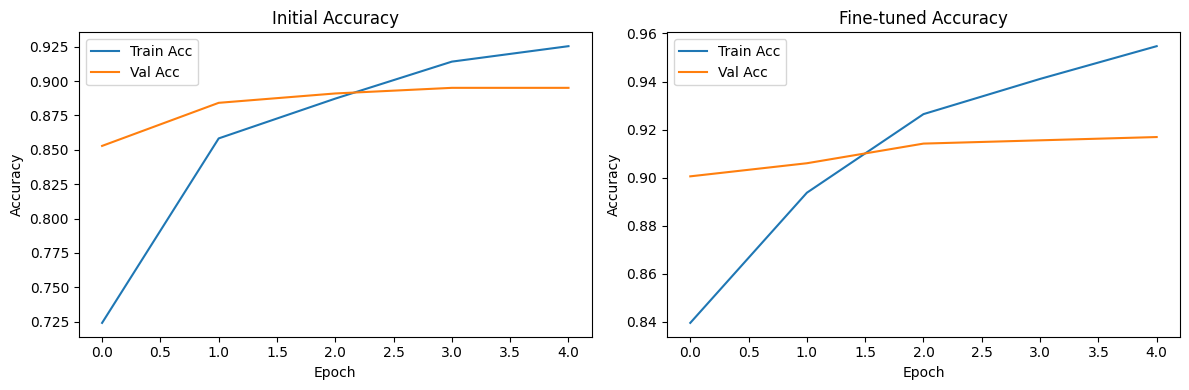

In [ ]:
# flowers_transfer_learning.py

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 5

# Load the Flowers dataset
(train_ds, val_ds), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

# Preprocessing function
def format_example(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
    return image, label

# Prepare datasets
train_ds = train_ds.map(format_example).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(format_example).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Load MobileNetV2 base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Build the model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

# Optional fine-tuning
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_fine = model.fit(train_ds, validation_data=val_ds, epochs=5)

# Save the model
model.save('flowers_mobilenetv2.h5')

# Plot training history
def plot_history(histories, titles):
    plt.figure(figsize=(12, 4))
    for i, (history, title) in enumerate(zip(histories, titles)):
        plt.subplot(1, 2, i+1)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title(f'{title} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_history([history, history_fine], ['Initial', 'Fine-tuned'])
